# Machine Learning for San Diego

In [1]:
# Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import datetime
import glob

import warnings
warnings.filterwarnings('ignore')

from wordcloud import WordCloud
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to C:\Users\Ryan
[nltk_data]     Luu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
#path = 'C:/Users/Ryan/Documents/Github/ML-SD-Project/'
path = 'C:/Users/Ryan Luu/Documents/Github/ML-SD-Project/'

all_files = glob.glob(path + "data/*.csv")

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)

raw = pd.concat(li, axis=0, ignore_index=True)


In [3]:
raw.head()

,service_request_id,service_request_parent_id,sap_notification_number,date_requested,case_age_days,service_name,case_record_type,date_updated,status,lat,lng,council_district,comm_plan_code,comm_plan_name,park_name,case_origin,referred,public_description
0,80477,NaN,NaN,2016-05-20T00:08:00,15.0,Other,TSW,2016-06-03T00:00:00,Closed,NaN,NaN,NaN,NaN,NaN,NaN,Email,NaN,Name : JackEmail : bcjack@hotmail.comAddress...
1,80478,NaN,NaN,2016-05-20T05:04:00,NaN,Parking Meter,TSW,NaN,Referred,32.726553,-117.125296,3.0,8.0,Greater Golden Hill,NaN,Mobile,NaN,NaN
2,80479,NaN,NaN,2016-05-20T05:05:00,NaN,72 Hour Violation,Parking,NaN,Referred,32.726523,-117.125532,3.0,8.0,Greater Golden Hill,NaN,Mobile,NaN,NaN
3,80480,NaN,NaN,2016-05-20T05:05:00,NaN,Dead Animal,TSW,NaN,Referred,32.726365,-117.125478,3.0,8.0,Greater Golden Hill,NaN,Mobile,NaN,NaN
4,80481,NaN,NaN,2016-05-20T05:06:00,0.0,Graffiti Removal,TSW,2016-05-20T00:00:00,Closed,32.726445,-117.125476,3.0,8.0,Greater Golden Hill,NaN,Mobile,NaN,Test


In [4]:
print("There are " + str(raw.shape[0]) + " observations and " + str(raw.shape[1]) + " variables.")

There are 681427 observations and 18 variables.


# Data Cleaning and Manipulation

In [5]:
# Remove unnecessary columns
raw = raw.drop(["service_request_id", "service_request_parent_id", "sap_notification_number"], axis=1)

In [6]:
df = raw
# Convert back into datetime64
df['date_requested'] = pd.to_datetime(df['date_requested'])

# Extract date, month, time
df['date'] = df.date_requested.dt.date 
df['month'] = df.date_requested.dt.month
df['time'] = df.date_requested.dt.time


# Make new Season Variable
df['season'] = (df.date_requested.dt.month%12 + 3)//3

# Month 
df.month[df.month == 1] = 'Jan'
df.month[df.month == 2] = 'Feb'
df.month[df.month == 3] = 'Mar'
df.month[df.month == 4] = 'Apr'
df.month[df.month == 5] = 'May'
df.month[df.month == 6] = 'Jun'
df.month[df.month == 7] = 'Jul'
df.month[df.month == 8] = 'Aug'
df.month[df.month == 9] = 'Jan'
df.month[df.month == 10] = 'Oct'
df.month[df.month == 11] = 'Nov'
df.month[df.month == 12] = 'Dec'

# Season
df.season[df.season ==1] = 'Winter'
df.season[df.season ==2] = 'Spring'
df.season[df.season ==3] = 'Summer'
df.season[df.season ==4] = 'Fall'

# Make new DOW variable
df['dow'] = df['date'].apply(lambda x: pd.Timestamp(str(x)).weekday_name)

#Cleaning and replacing nan in council district with 0
df['council_district'] = df.council_district.fillna(0)
df['council_district'] = df.council_district.astype(np.int64)
df['council_district'] = df.council_district.apply(lambda x: 'district ' + str(x))

# Cleaning and Remove nan obsertation in case age days
df = df.dropna(subset=['case_age_days'])
df['case_age_days'] = df.case_age_days.astype(np.int64)

# Setting Conditions for Dataframe
df['lat'] = df['lat'].astype(float)
df['lng'] = df['lng'].astype(float)
df2 = df[(df['lat'] > 32.5444) &
        (df['lat'] < 33.4274) &
        (df['lng'] < -117.0301) &
        (df['lng'] > -117.6126) &
        (df['status'] == 'Closed')]

df2.head()

,date_requested,case_age_days,service_name,case_record_type,date_updated,status,lat,lng,council_district,comm_plan_code,comm_plan_name,park_name,case_origin,referred,public_description,date,month,time,season,dow
4,2016-05-20 05:06:00,0,Graffiti Removal,TSW,2016-05-20T00:00:00,Closed,32.726445,-117.125476,district 3,8.0,Greater Golden Hill,NaN,Mobile,NaN,Test,2016-05-20,May,05:06:00,Spring,Friday
17,2016-05-20 07:19:00,14,Graffiti Removal,TSW,2016-06-03T00:00:00,Closed,32.735047,-117.080075,district 4,57.0,Mid-City:Eastern Area,NaN,Phone,NaN,Graffiti on the wall in front of the library,2016-05-20,May,07:19:00,Spring,Friday
25,2016-05-20 08:47:00,0,Street Light Out,TSW,2016-05-20T00:00:00,Closed,32.722676,-117.127614,district 3,8.0,Greater Golden Hill,NaN,Web,NaN,test,2016-05-20,May,08:47:00,Spring,Friday
26,2016-05-20 08:48:00,0,Street Light on During Day,TSW,2016-05-20T00:00:00,Closed,32.711953,-117.159211,district 3,4.0,Downtown,NaN,Web,NaN,"test only, please don't create a notification",2016-05-20,May,08:48:00,Spring,Friday
27,2016-05-20 08:53:00,0,Street Light Out,TSW,2016-05-20T00:00:00,Closed,32.763104,-117.117315,district 3,59.0,Mid-City:Normal Heights,NaN,Web,NaN,test,2016-05-20,May,08:53:00,Spring,Friday


In [7]:
df.ftypes

date_requested        datetime64[ns]:dense
case_age_days                  int64:dense
service_name                  object:dense
case_record_type              object:dense
date_updated                  object:dense
status                        object:dense
lat                          float64:dense
lng                          float64:dense
council_district              object:dense
comm_plan_code               float64:dense
comm_plan_name                object:dense
park_name                     object:dense
case_origin                   object:dense
referred                      object:dense
public_description            object:dense
date                          object:dense
month                         object:dense
time                          object:dense
season                        object:dense
dow                           object:dense
dtype: object

In [8]:
#df2.to_csv(path + "data/get_it_done_full.csv", encoding='utf-8', index=False)

# Exploratory Data Analysis

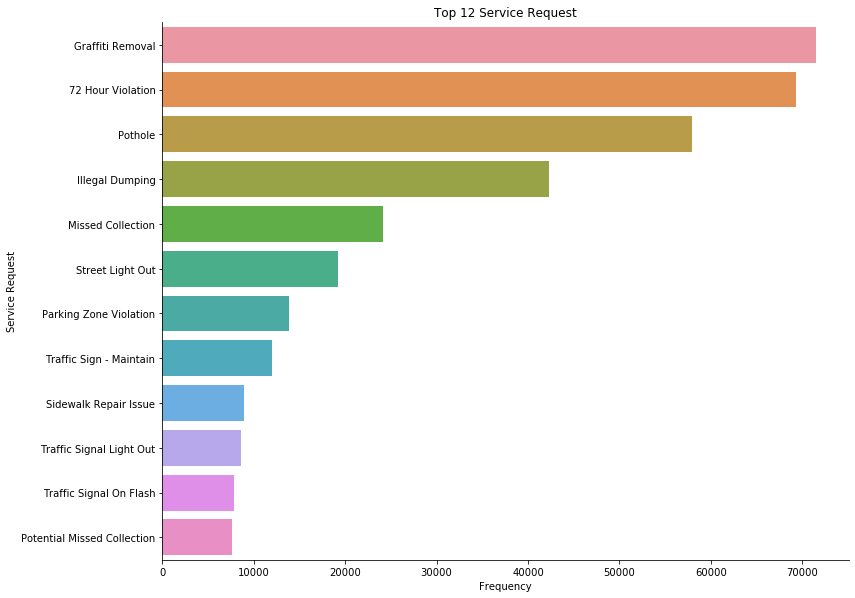

In [9]:
a= sns.catplot(y = 'service_name',
           kind = 'count',
           height = 8,
           aspect = 1.5,
           order = df2.service_name.value_counts().head(12).index,
           data = df2)
plt.title("Top 12 Service Request")
a.set(xlabel='Frequency', ylabel='Service Request')

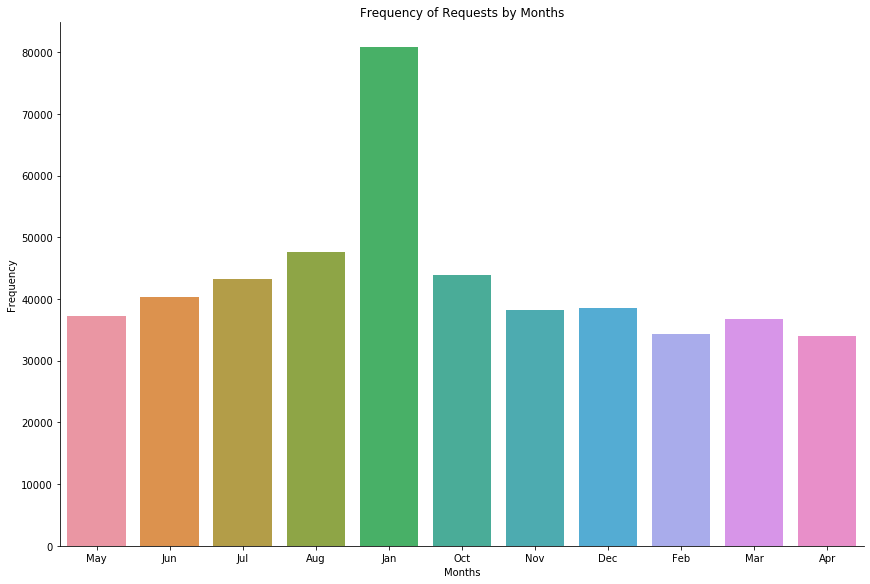

In [10]:
a = sns.catplot(x='month',
            kind='count',
            height=8, 
            aspect=1.5,
            data=df2)

plt.title("Frequency of Requests by Months")
a.set(xlabel="Months",ylabel="Frequency")
plt.show()

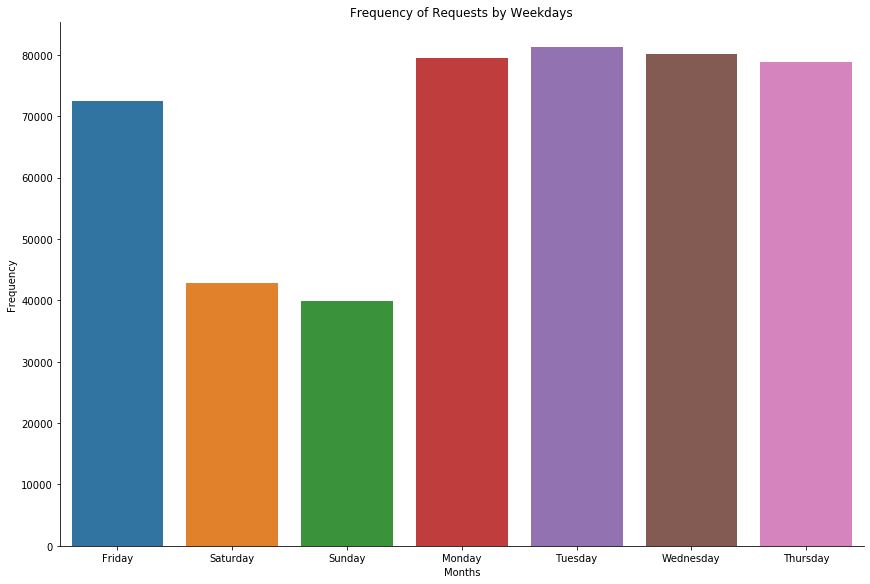

In [11]:
a = sns.catplot(x='dow',
            kind='count',
            height=8, 
            aspect=1.5,
            data=df2)

plt.title("Frequency of Requests by Weekdays")
a.set(xlabel="Months",ylabel="Frequency")
plt.show()

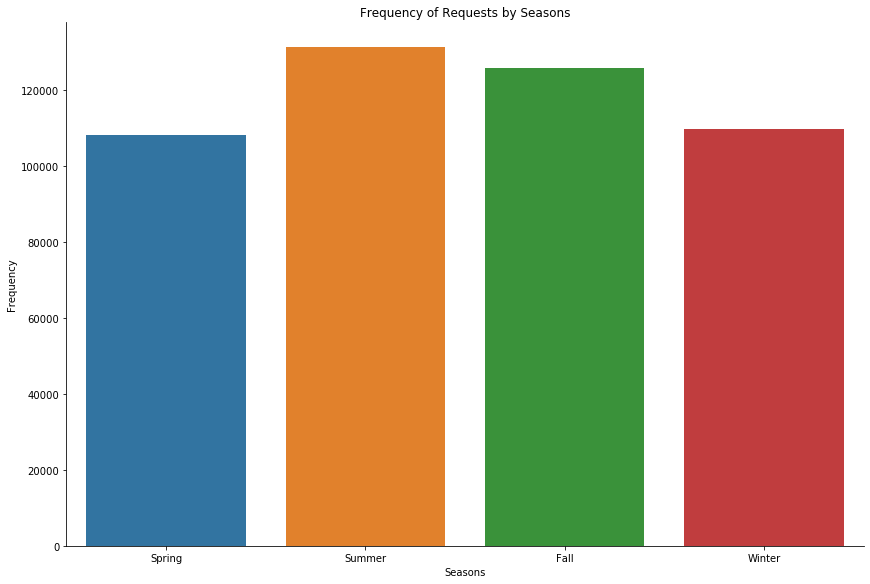

In [12]:
a = sns.catplot(x='season',
            kind='count',
            height=8, 
            aspect=1.5,
            data=df2)

plt.title("Frequency of Requests by Seasons")
a.set(xlabel="Seasons",ylabel="Frequency")
plt.show()

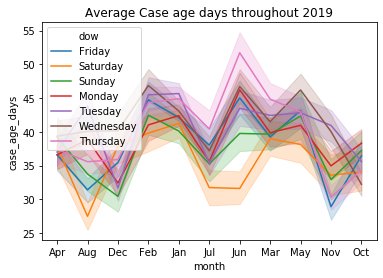

In [13]:
c = sns.lineplot(x="month",
                y="case_age_days",
                hue='dow',
                data=df2
                ).set_title('Average Case age days throughout 2019')
plt.show()

# WordCloud

In [14]:
desc = df2[['public_description']].dropna()

In [15]:
print('In the review dataframe, there are ' + 
      str(desc.shape[0]) + 
      ' observations and ' + 
     str(desc.shape[1]) +
     ' features.')

In the review dataframe, there are 392674 observations and 1 features.


In [16]:
string = (desc.to_string()).lower()

In [17]:
s = stopwords.words('english')
print(s)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

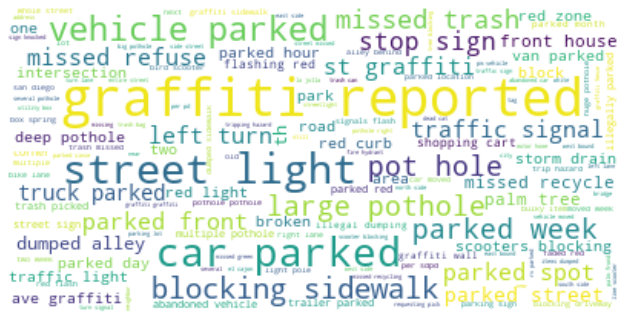

In [18]:
wordcloud = WordCloud(stopwords = s, background_color='white').generate(string)

# Plot
plt.figure(figsize=(11,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# New Dataframe

In [19]:
df2.case_age_days[df2['service_name'] == 'Graffiti Removal'].median()

8.0

In [20]:
def norm(x):
    r = (x-min(x))/(max(x)-min(x))
    return(r)

In [21]:
# Convert into categorical
df2['season'] = df['season'].astype('category')
df2['dow'] = df['dow'].astype('category')
df2['case_record_type'] = df['case_record_type'].astype('category')
df2['council_district'] = df['council_district'].astype('category')
df2['month'] = df['month'].astype('category')
df2['referred'] = df['referred'].astype('category')
df2['case_origin'] = df['case_origin'].astype('category')
df2['service_name'] = df['service_name'].astype('category')


#df2['case_age_days'] = df['case_age_days'].apply(np.int64)

df2.ftypes

date_requested        datetime64[ns]:dense
case_age_days                  int64:dense
service_name                category:dense
case_record_type            category:dense
date_updated                  object:dense
status                        object:dense
lat                          float64:dense
lng                          float64:dense
council_district            category:dense
comm_plan_code               float64:dense
comm_plan_name                object:dense
park_name                     object:dense
case_origin                 category:dense
referred                    category:dense
public_description            object:dense
date                          object:dense
month                       category:dense
time                          object:dense
season                      category:dense
dow                         category:dense
dtype: object

In [22]:
df3 = pd.get_dummies(df2, columns=['dow'], prefix = [''])
df4 = pd.get_dummies(df3, columns=['month'], prefix = [''])
df5 = pd.get_dummies(df4, columns=['season'], prefix = [''])
df6 = pd.get_dummies(df5, columns=['council_district'], prefix = [''])
df7 = pd.get_dummies(df6, columns =['case_record_type'], prefix = [''])

df7['normLat'] = norm(df7.lat)
df7['normLng'] = norm(df7.lng)


df7.head()

# Drop date_requested
#df = df.drop(["date_requested"], axis=1)

,date_requested,case_age_days,service_name,date_updated,status,lat,lng,comm_plan_code,comm_plan_name,park_name,...,_district 9,_DSD,_ESD Complaint/Report,_Parking,_Storm Water Code Enforcement,_TSW,_TSW ROW,_Traffic Engineering,normLat,normLng
4,2016-05-20 05:06:00,0,Graffiti Removal,2016-05-20T00:00:00,Closed,32.726445,-117.125476,8.0,Greater Golden Hill,NaN,...,0,0,0,0,0,1,0,0,0.241415,0.729236
17,2016-05-20 07:19:00,14,Graffiti Removal,2016-06-03T00:00:00,Closed,32.735047,-117.080075,57.0,Mid-City:Eastern Area,NaN,...,0,0,0,0,0,1,0,0,0.252822,0.858126
25,2016-05-20 08:47:00,0,Street Light Out,2016-05-20T00:00:00,Closed,32.722676,-117.127614,8.0,Greater Golden Hill,NaN,...,0,0,0,0,0,1,0,0,0.236418,0.723166
26,2016-05-20 08:48:00,0,Street Light on During Day,2016-05-20T00:00:00,Closed,32.711953,-117.159211,4.0,Downtown,NaN,...,0,0,0,0,0,1,0,0,0.222197,0.633467
27,2016-05-20 08:53:00,0,Street Light Out,2016-05-20T00:00:00,Closed,32.763104,-117.117315,59.0,Mid-City:Normal Heights,NaN,...,0,0,0,0,0,1,0,0,0.290030,0.752406


In [23]:
df7.tail()

,date_requested,case_age_days,service_name,date_updated,status,lat,lng,comm_plan_code,comm_plan_name,park_name,...,_district 9,_DSD,_ESD Complaint/Report,_Parking,_Storm Water Code Enforcement,_TSW,_TSW ROW,_Traffic Engineering,normLat,normLng
681420,2019-12-31 23:08:00,1,NaN,2020-01-02T00:00:00,Closed,32.799915,-117.244770,27.0,Pacific Beach,NaN,...,0,0,0,1,0,0,0,0,0.338846,0.390570
681422,2019-12-31 23:28:00,1,Citizen Contact,2020-01-02T00:00:00,Closed,32.707425,-117.093231,11.0,Encanto Neighborhoods,NaN,...,0,0,0,1,0,0,0,0,0.216192,0.820778
681423,2019-12-31 23:32:00,6,72 Hour Violation,2020-01-07T00:00:00,Closed,32.767174,-117.122808,59.0,Mid-City:Normal Heights,NaN,...,0,0,0,1,0,0,0,0,0.295427,0.736812
681424,2019-12-31 23:35:00,1,Citizen Contact,2020-01-02T00:00:00,Closed,32.751146,-117.250123,23.0,Ocean Beach,NaN,...,0,0,0,1,0,0,0,0,0.274173,0.375375
681425,2019-12-31 23:45:00,2,Illegal Dumping,2020-01-03T00:00:00,Closed,32.709147,-117.059223,11.0,Encanto Neighborhoods,NaN,...,0,0,1,0,0,0,0,0,0.218476,0.917324


# Test and Train